# UTE - Precipitation Data
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@description**: Anexo de la altitud al dataset de los pluviómetros
 - **Data Source**:  ../02 - DataSource/
 - **Output**: 
  - **ute_daily_2000_2020_ext.nc** (Dataset netCDF unificado de las estaciones ute con anexo de geodatos de altitud)
 
  - mater_ute_daily_2000_2020_ext.nc (Dataset netCDF ute_daily_2000_2020_ext.nc que ha pasado control de calidad y puede ser utilizado para la próxima etapa)

 - **Input**: 
   - ***master_ute_daily_2000_2020.nc*** (Dataset netCDF con la informacion de los pluviometros con lat/lon.)
 - **@version**: v1.3
 - **@date**: 2022-08-10,  2022-08-06, 2022-08-01, 2022-07-30, 2022-07-26   

## Setup

In [ ]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/04 - Data Ext"
dir_google_drive_output = dir_google_drive+'/datasets/output/'
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'



### Libraries

In [ ]:
# https://pypi.org/project/wget/
!pip install wget

In [ ]:
!pip install geopandas 

In [ ]:
# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import wget
import os 
import shutil
import glob

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [ ]:
# Geo elevation data parser for "The Shuttle Radar Topography Mission" data
!pip install SRTM.py

In [ ]:
# https://www.usna.edu/Users/oceano/pguth/md_help/html/srtm.htm
# importante el siguiente link
# http://viewfinderpanoramas.org/Coverage%20map%20viewfinderpanoramas_org3.htm 
#  for f in ['SG21','SG22',   'SH21','SH22',  'SI21','SI22',  'SJ21']:

%%bash
mkdir -p /content/var/log
mkdir -p /content/var/download
mkdir -p /root/.cache/srtm/

cat > /content/var/download/download.txt << EOF
http://viewfinderpanoramas.org/dem3/SG21.zip 
http://viewfinderpanoramas.org/dem3/SG22.zip 
http://viewfinderpanoramas.org/dem3/SH21.zip 
http://viewfinderpanoramas.org/dem3/SH22.zip 
http://viewfinderpanoramas.org/dem3/SI21.zip 
http://viewfinderpanoramas.org/dem3/SI22.zip 
http://viewfinderpanoramas.org/dem3/SJ21.zip 
EOF

wget  -P /content/var/download \
      --no-clobber --continue --wait=1 \
      -o /content/var/log/wget.log \
      -i "/content/var/download/download.txt"  

unzip -o /content/var/download/SG22.zip  -d /content/var/download/
unzip -o /content/var/download/SG22.zip  -d /content/var/download/
unzip -o /content/var/download/SH21.zip  -d /content/var/download/
unzip -o /content/var/download/SH22.zip  -d /content/var/download/
unzip -o /content/var/download/SI21.zip  -d /content/var/download/
unzip -o /content/var/download/SI22.zip  -d /content/var/download/
unzip -o /content/var/download/SJ21.zip  -d /content/var/download/

mv -v /content/var/download/G22/*  /root/.cache/srtm
mv -v /content/var/download/G22/*  /root/.cache/srtm
mv -v /content/var/download/H21/*  /root/.cache/srtm
mv -v /content/var/download/H22/*  /root/.cache/srtm
mv -v /content/var/download/I21/*  /root/.cache/srtm
mv -v /content/var/download/I22/*  /root/.cache/srtm
mv -v /content/var/download/J21/*  /root/.cache/srtm

ls -lhas /root/.cache/srtm/ 

In [ ]:
import srtm
elevation_data = srtm.get_data()

# Check if is NaN
def is_nan(x):
    return (x != x)
    
def get_elevation(lat, lon):
    if is_nan(lat):
        return ''
    if is_nan(lon):
        return ''
    
    return elevation_data.get_elevation(lat,lon,approximate=True)

In [ ]:
def fill_altitude(ds_xr):
  # ndarray_date = ds_xr.coords['time'].values		
  ndarray_lat = ds_xr.coords['lat'].values		
  ndarray_lon = ds_xr.coords['lon'].values	

  df_lat_lon = []

  for lat in ndarray_lat:
    for lon in ndarray_lon:
      df_lat_lon.append([lat,lon])

  df_lat_lon = pd.DataFrame(df_lat_lon, columns=['lat','lon'])

  df_lat_lon['alt'] = df_lat_lon.apply(lambda x: get_elevation(x['lat'], x['lon']), axis=1)
  df_lat_lon.set_index(['lat','lon'], inplace=True)

  return df_lat_lon

In [ ]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  # df_uruguay_shapes
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay
  # polygon_uruguay = geometry[210]
  # return gpd.GeoSeries(polygon_uruguay)

### Init

In [ ]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"

!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 


## Download Data

In [ ]:
filename = dir_data_source+"/master_ute_daily_2000_2020.nc"
!gdown -O $filename "1yd-N46Ukz7hjVxtqG89Mrl-wT5xQJK9d"

Downloading...
From: https://drive.google.com/uc?id=1yd-N46Ukz7hjVxtqG89Mrl-wT5xQJK9d
To: /content/data/source/master_ute_daily_2000_2020.nc
100% 2.61M/2.61M [00:00<00:00, 208MB/s]


In [ ]:
ds_xr = xr.open_dataset(filename)
ds_xr

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 ...

## Reordering Dimensions

In [ ]:
ds_xr.dims

Frozen({'time': 7671, 'lat': 139, 'lon': 140})

In [ ]:
ds_xr_ext = ds_xr.transpose( "time", "lat", "lon")
ds_xr_ext

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 ...

In [ ]:
# ul (upper-left) ur (upper-right)
# ll (lower-left) lr (lower-right)

# We're using coors from  ul (upper-left) 

ds_xr_ext = ds_xr_ext.sortby('time', ascending=True)
ds_xr_ext = ds_xr_ext.sortby('lat', ascending=False)
ds_xr_ext = ds_xr_ext.sortby('lon', ascending=True)
ds_xr_ext

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -30.9 -31.1 -31.19 ... -33.86 -33.87 -33.88
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 ...

## Add Altitude

In [ ]:
df_lat_lon = fill_altitude(ds_xr_ext)
df_lat_lon

alt
lat        lon             
-30.896473 -58.318111  63.0
           -58.237000  66.0
           -58.068611  51.0
           -57.974167  32.0
           -57.900223  38.5
...                     ...
-33.878971 -54.159168  31.5
           -54.123669  27.5
           -54.048279  32.0
           -53.954723  65.5
           -53.787971  16.0

[19460 rows x 1 columns]

In [ ]:
df_ll_pivot = df_lat_lon.reset_index().pivot(index='lat', columns='lon', values='alt')

# We're using coors from  ul (upper-left) 
df_ll_pivot = df_ll_pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

df_ll_pivot


lon,-58.318111,-58.237000,-58.068611,-57.974167,-57.900223,-57.798279,-57.788055,-57.784138,-57.732529,-57.711666,...,-54.309193,-54.213749,-54.192307,-54.162888,-54.160999,-54.159168,-54.123669,-54.048279,-53.954723,-53.787971
lat,,,,,,,,,,,,,,,,,,,,,
-30.896473,63.0,66.0,51.0,32.0,38.5,32.0,32.0,32.0,38.0,64.5,...,292.5,303.5,282.5,280.0,293.0,300.5,346.0,384.5,275.5,179.0
-31.095388,71.0,63.0,47.0,64.0,32.0,48.0,58.5,71.5,84.5,77.0,...,278.5,336.0,352.0,339.5,341.0,334.0,343.5,314.0,344.0,329.0
-31.190779,53.5,39.5,66.0,32.0,32.0,40.0,32.0,32.0,50.5,49.5,...,285.0,309.5,341.5,364.5,364.5,362.5,354.0,365.5,358.0,346.5
-31.201082,59.0,45.5,56.5,32.0,32.0,35.5,35.5,33.5,56.5,54.0,...,278.5,317.0,323.5,363.5,362.0,362.0,357.5,371.5,357.5,344.5
-31.393999,39.0,28.5,29.0,19.5,53.5,55.0,54.0,58.0,85.0,91.0,...,187.0,178.5,166.0,177.5,179.0,184.0,170.5,167.5,191.5,256.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-33.828751,38.0,30.0,72.5,76.0,65.0,69.5,81.0,81.0,90.0,79.0,...,49.0,32.5,28.0,28.0,28.0,28.0,26.0,26.0,26.0,8.5
-33.829582,34.0,31.5,71.5,77.5,65.0,71.5,81.0,81.0,86.5,78.5,...,49.5,33.0,28.5,27.0,28.0,29.0,25.0,25.5,26.5,8.5
-33.862556,31.0,22.5,69.5,89.5,88.5,106.0,92.5,85.0,84.0,92.5,...,49.5,41.5,31.5,27.5,27.5,28.0,26.5,25.0,26.0,11.0


In [ ]:
# Add altitude
ds_xr_ext['altitude'] = (['lat','lon'], df_ll_pivot.to_numpy())
ds_xr_ext['altitude'] = ds_xr_ext['altitude'].astype(np.float32)
ds_xr_ext

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -30.9 -31.1 -31.19 ... -33.86 -33.87 -33.88
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 ...
    altitude       (lat, lon) float32 63.0 66.0 51.0 32.0 ... 32.0 65.5 16.0

In [ ]:
# display(ds_xr_ext['altitude'][0,0]) # lat -30.25   lon -58.50   alt 70.5
# display(ds_xr_ext['altitude'][0,2]) # lat -30.25   lon -58.00   alt 65.0
# display(ds_xr_ext['altitude'][2,0]) # lat -30.75   lon -58.50   alt 71.0
# display(ds_xr_ext['altitude'][2,2]) # lat -30.75   lon -58.00   alt 67.5

## Add Meta Data

In [ ]:
import datetime 
ds_xr_ext.attrs = {
    'creation_date': '2022-07-27', 
    'author':'Mario Garcia', 
    'email':'mariogarcia.ar@gmail.com',

    'algorithm': 'ute',
    'url': '',
    'type': 'gauge-based precipitation products',
    'spatial resolution': '',
    'time resolution': '1 day',
    }

# ds_xr_ext['date'].attrs = {'units':'datetime', 'long_name':'Date'}
ds_xr_ext['lat'].attrs = {'units':'decimal degrees', 'long_name':'Latitude'}
ds_xr_ext['lon'].attrs = {'units':'decimal degrees', 'long_name':'Longitude'}
ds_xr_ext

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -30.9 -31.1 -31.19 ... -33.86 -33.87 -33.88
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 ...
    altitude       (lat, lon) float32 63.0 66.0 51.0 32.0 ... 32.0 65.5 16.0
Attributes:
    creation_date:       2022-07-27
    author:              Mario Garcia
    email:               mariogarcia.ar@gmail.com
    algorithm:           ute
    url:                 
    type:                gauge-based precipitation products
    spatial resolution:  
    time resolution:     1 day

In [ ]:
ds_xr_ext.info()

xarray.Dataset {
dimensions:
	time = 7671 ;
	lat = 139 ;
	lon = 140 ;

variables:
	float32 precipitation(time, lat, lon) ;
	datetime64[ns] time(time) ;
	float32 lat(lat) ;
		lat:units = decimal degrees ;
		lat:long_name = Latitude ;
	float32 lon(lon) ;
		lon:units = decimal degrees ;
		lon:long_name = Longitude ;
	float32 altitude(lat, lon) ;

// global attributes:
	:creation_date = 2022-07-27 ;
	:author = Mario Garcia ;
	:email = mariogarcia.ar@gmail.com ;
	:algorithm = ute ;
	:url =  ;
	:type = gauge-based precipitation products ;
	:spatial resolution =  ;
	:time resolution = 1 day ;
}

## Export

In [ ]:
file_nc = dir_output+'/ute_daily_2000_2020_ext.nc'
ds_xr_ext.to_netcdf(file_nc)

In [ ]:
# Export to drive
!cp "$file_nc" "$dir_google_drive_output" 

## Plot

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


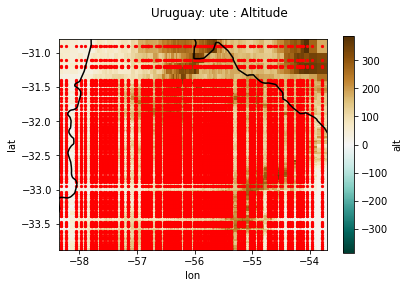

In [ ]:
# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

geometry=[Point(xy) for xy in zip(df_lat_lon.reset_index()['lon'], df_lat_lon.reset_index()['lat'])]

fig, axs = plt.subplots()  

df_lat_lon.to_xarray()['alt'].plot(ax=axs, cmap="BrBG_r",) #terrain BrBG_r

df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs, color='red', markersize=5)

geodf_shape.boundary.plot(ax=axs, color="black")


fig.suptitle(f'Uruguay: ute : Altitude ', fontsize=12)
plt.show()